# Fault Detection in the gluing of the last layer of cardboard

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

## Image Import

We find the current directory and import the related image

In [53]:
# Get the current working directory
baseFolder = os.getcwd()

# Define the folder containing the images
folder = os.path.join(baseFolder, "photos", "largeBubbles")

# Read the image in grayscale
img = cv.imread(os.path.join(folder, "1.png"),0)

print("Image Shape: ", img.shape)
print("Image min: ", img.min())
print("Image max: ", img.max())

img_shown = cv.resize(img, (600, 800))

# The image with the corners is shown
cv.imshow('Loaded Image', img_shown) # We show the found corners in the image
cv.waitKey(1000)
cv.destroyAllWindows()

Image Shape:  (1216, 1936)
Image min:  23
Image max:  255


## Calibration Parameters

The photos for this fault detection were taken in the first setup, based on that we load the camera parameters found during the calibration procedure

In [54]:
# We load the camera calibration results (We took the photos with the first camera setup)
cameraParameters = np.load(baseFolder + "/calibration/camera_setup1.npz")

# We extract the camera matrix and distortion coefficients, through the keys in the dictionary
mtx = cameraParameters['mtx']
dist = cameraParameters['dist']

## Undistorting the image

Based on the calibration procedure carried out, we are able to undistort the image of the cardboard

(np.float64(-0.5), np.float64(1921.5), np.float64(1201.5), np.float64(-0.5))

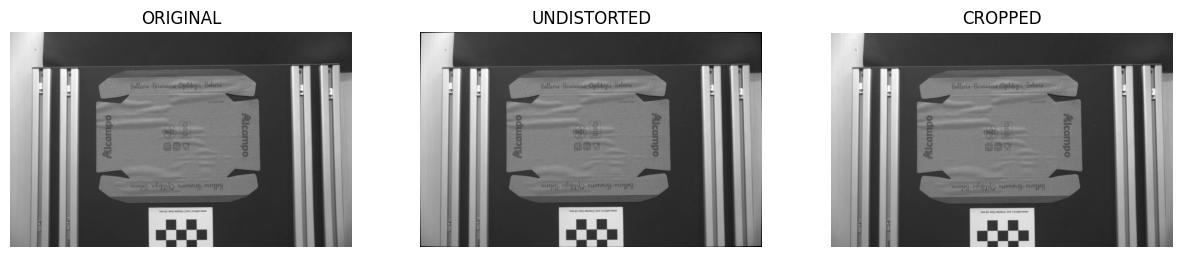

In [55]:
# We find the dimensions of the image
h, w = img.shape[:2]

# We find the new camera matrix and interested region
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# We undistort the image
udst_img = cv.undistort(img, mtx, dist, None, newcameramtx)

# We crop the image using the ROI
x_r, y_r, w_r, h_r = roi
udst_crop_img = udst_img[y_r:y_r+h_r, x_r:x_r+w_r]

# We show the images
plt.figure(figsize=(15, 10))

plt.subplot(1,3,1)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.title("ORIGINAL")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(udst_img, cmap="gray", vmin=0, vmax=255)
plt.title("UNDISTORTED")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(udst_crop_img, cmap="gray", vmin=0, vmax=255)
plt.title("CROPPED")
plt.axis("off")

(np.float64(-0.5), np.float64(1921.5), np.float64(1201.5), np.float64(-0.5))

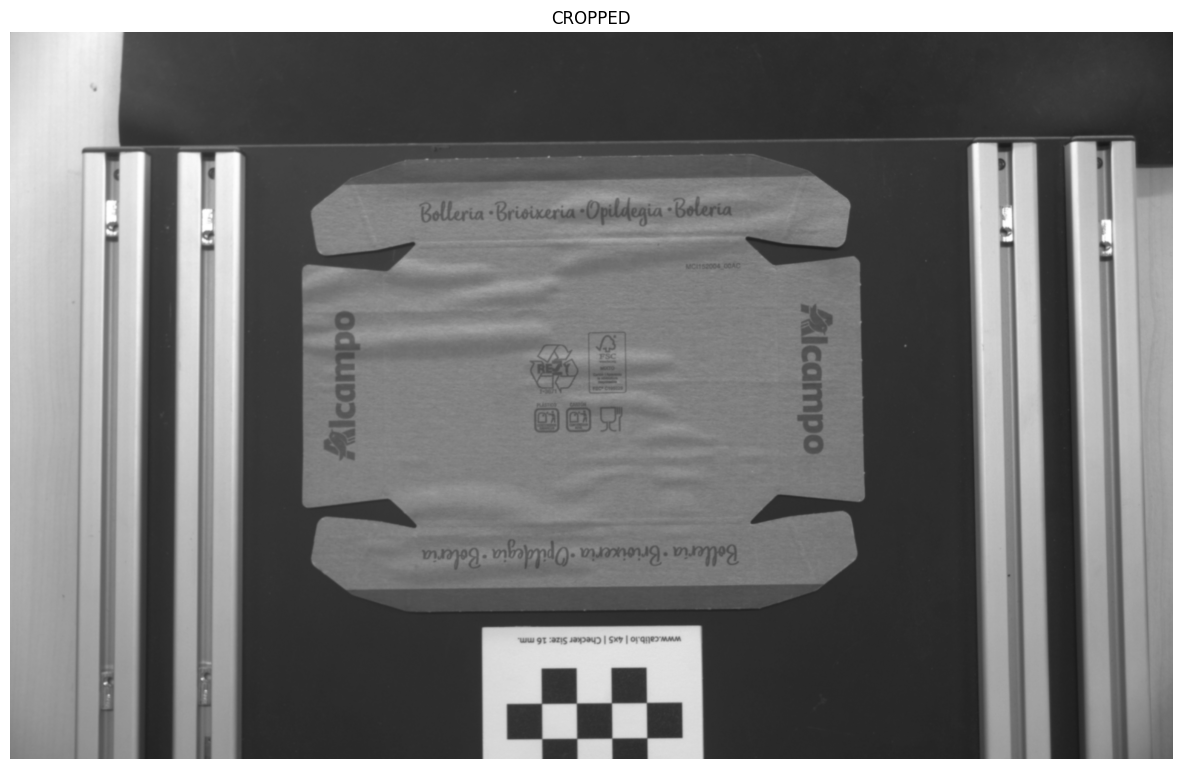

In [ ]:
# We show the croped image
plt.figure(figsize=(15, 10))
plt.imshow(udst_crop_img, cmap="gray", vmin=0, vmax=255)
plt.title("CROPPED")
plt.axis("off")

## Histogram Inspection

We plot the histogram of the image to have a good idea of the picture contents and how is it distributed along the grey scale

Text(0, 0.5, 'Frequency')

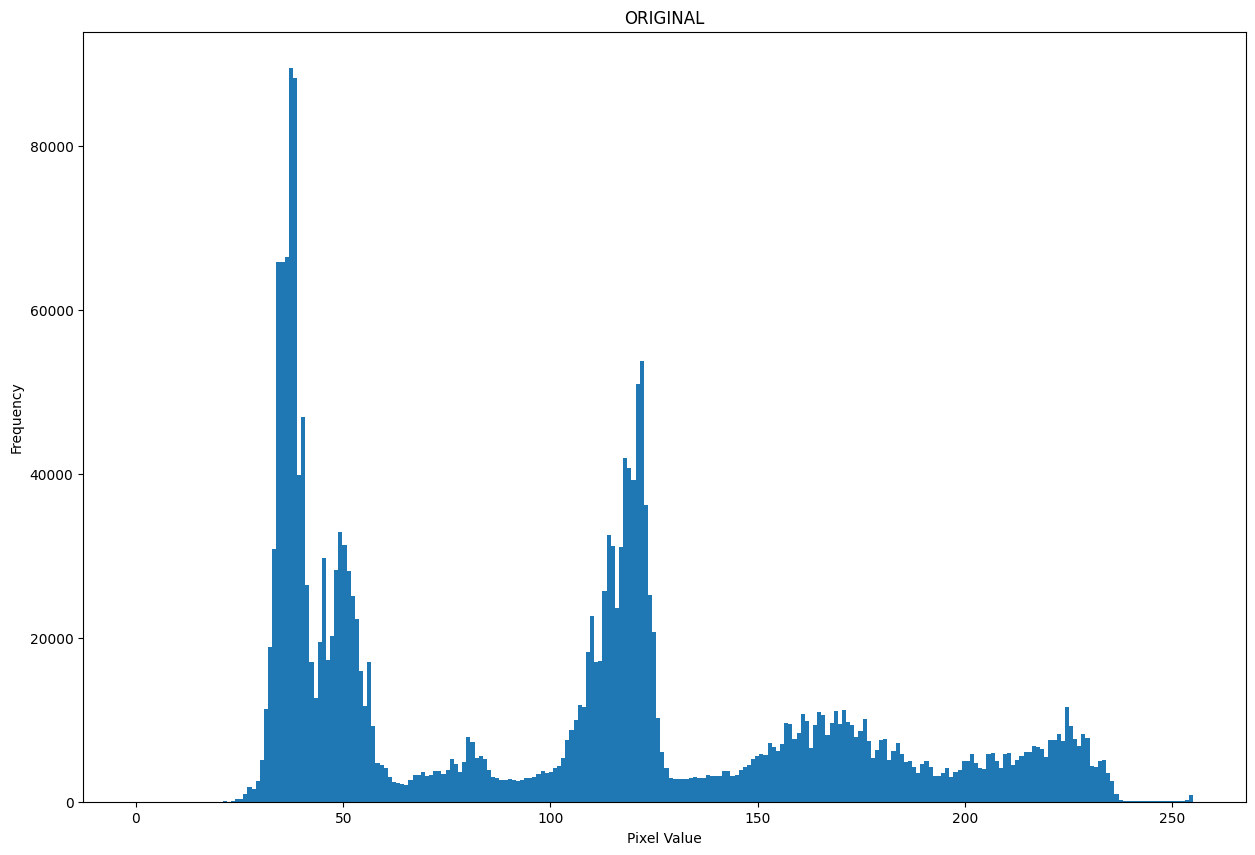

In [47]:
# We show the histogram of the image
plt.figure(figsize=(15, 10))
plt.hist(udst_crop_img.ravel(), bins=256, range=(0, 255))
plt.title("ORIGINAL")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

## Region of Interest

We want to focus on the section of the image, when we can find the cardboard, for that reason we are going to start by doing an optimal threshold of the image, using OTSU

(np.float64(-0.5), np.float64(1921.5), np.float64(1201.5), np.float64(-0.5))

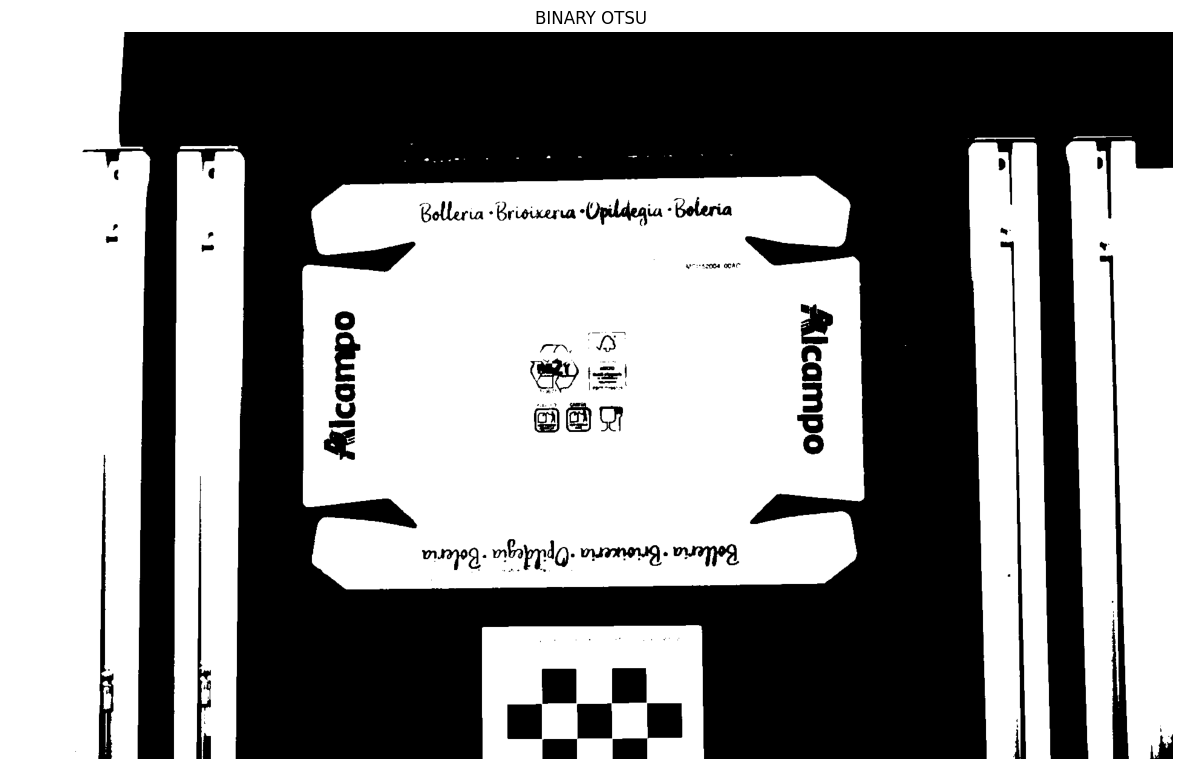

In [56]:
# Thresholding the imnage OTSU gives us the optimal threshold value
_ , th_Bin_OTSU = cv.threshold(udst_crop_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Let's see the results
plt.figure(figsize=(15, 10))
plt.imshow(th_Bin_OTSU, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("BINARY OTSU")
plt.axis("off")

We find the contours, and we know that the cardboard is going to be the larger one, in terms of area, finally we add a couple of pixels since due to the binary threshold employed, the red part of the cardbourd will be neglected

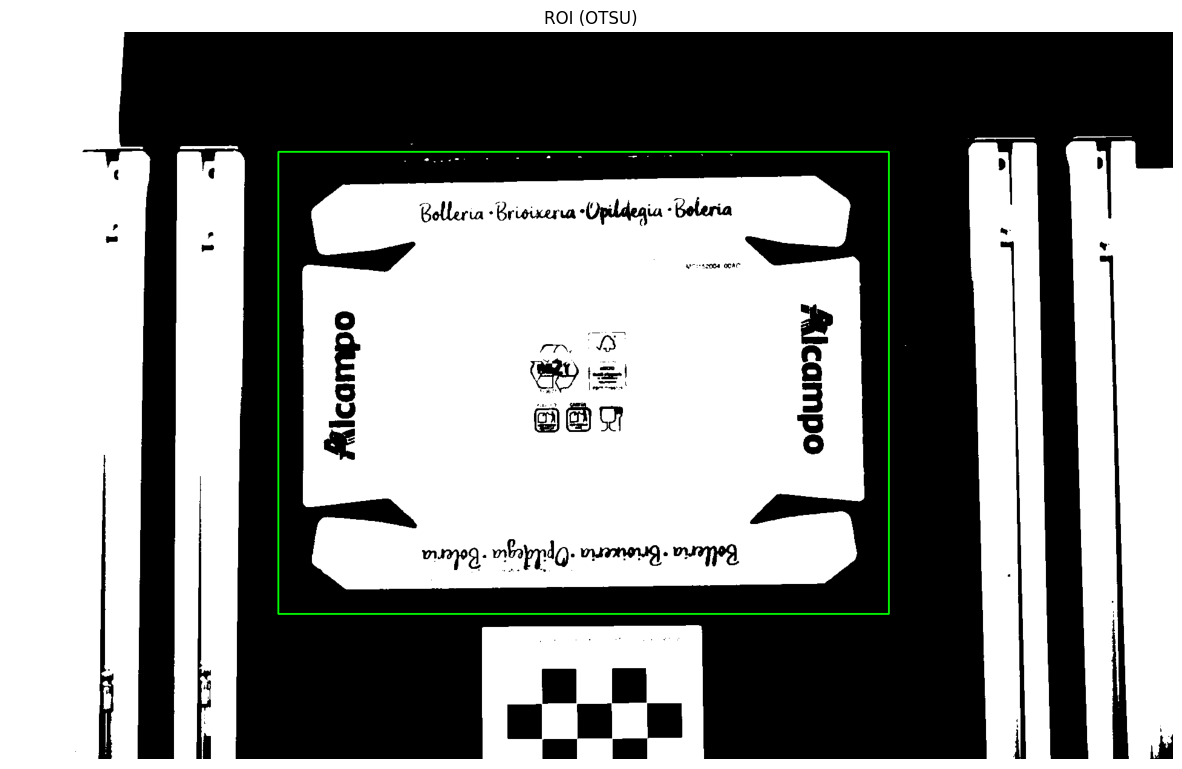

In [58]:
# Find the contours in the image
contours, _ = cv.findContours(th_Bin_OTSU, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# We search the biggest contour Area Based
contour_max = max(contours, key=cv.contourArea)

# Bounding box of the biggest contour
x, y, w, h = cv.boundingRect(contour_max)

# We expand the ROI
margin = 40  # Additional pixels to the ROI
x_roi = max(x - margin, 0)
y_roi = max(y - margin, 0)
w_roi = min(w + 2 * margin, th_Bin_OTSU.shape[1] - x_roi)
h_roi = min(h + 2 * margin, th_Bin_OTSU.shape[0] - y_roi)

# Draw a green rectangle using BGR
img_with_roi = cv.cvtColor(th_Bin_OTSU, cv.COLOR_GRAY2BGR)
cv.rectangle(img_with_roi, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi), (0, 255, 0), 2)

# We show the image with the ROI detected
plt.figure(figsize=(15, 10))
plt.imshow(img_with_roi)
plt.title("ROI (OTSU)")
plt.axis("off")
plt.show()


## Cardboard Edge Detection
We find the eges of the cardboard inside the ROI that we have selected

(1202, 1922)
[[68 68 68 ... 54 54 55]
 [67 68 68 ... 54 54 55]
 [67 68 67 ... 54 54 54]
 ...
 [47 47 48 ... 43 43 42]
 [47 47 48 ... 43 43 42]
 [48 48 48 ... 42 42 42]]
Borders detected: 6285


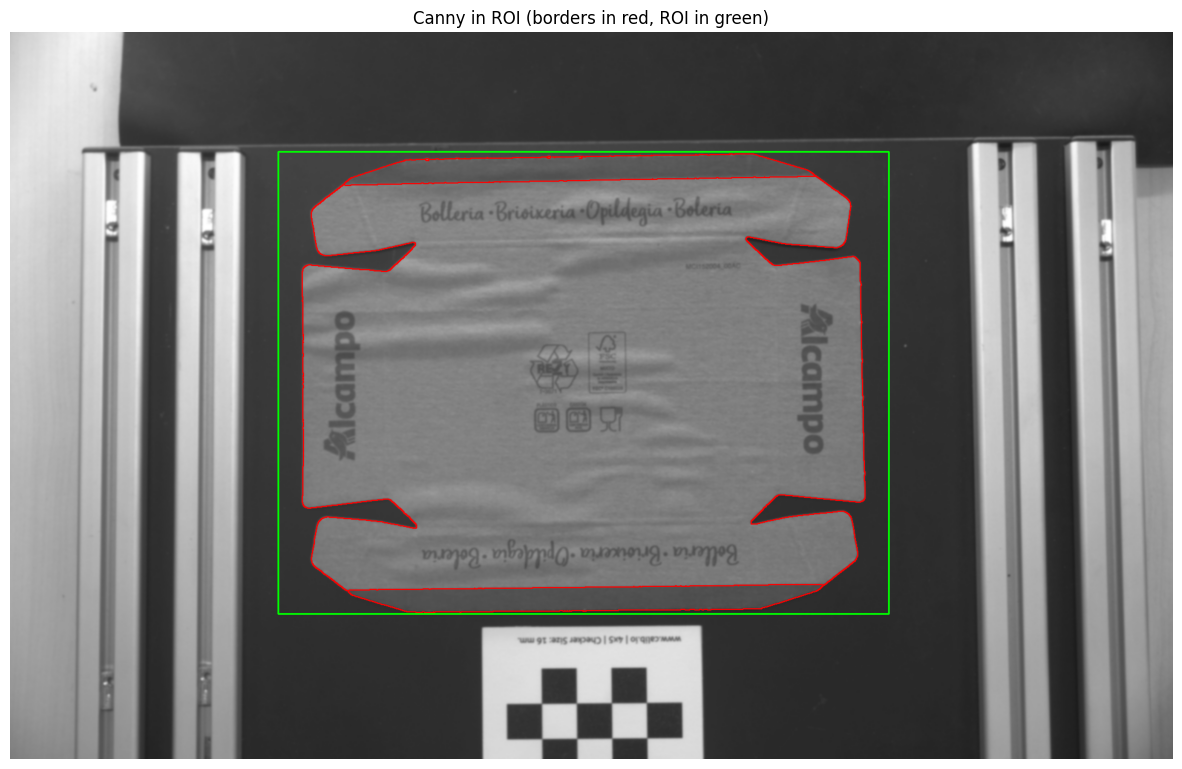

In [ ]:
# We distort the image
blur = cv.GaussianBlur(udst_crop_img, (5, 5), 0)

print(blur.shape)

# We use the ROI found in the previous step
roi = blur[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

# We apply the canny on the ROI
canny_edges_roi = cv.Canny(roi, 40, 130, L2gradient=True)
print("Borders detected:", np.count_nonzero(canny_edges_roi))

# Dilate the edges
kernel = np.ones((2, 2), np.uint8)
canny_edges = cv.dilate(canny_edges_roi, kernel, iterations=1)

# we make a color copy of the image
img_copy = blur.copy()
img_color_copy = cv.cvtColor(img_copy, cv.COLOR_GRAY2BGR)

# We draw the edges in red on the original image
mask = canny_edges > 0

# We draw the edges in red on the original image
roi_color = img_color_copy[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
roi_color[mask] = [0, 0, 255] # red (BGR)

# We draw a rectangle of the ROI in green
cv.rectangle(img_color_copy, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi), (0, 255, 0), 2)

# The results are shown
plt.figure(figsize=(15, 10))
plt.title("Canny in ROI (borders in red, ROI in green)")
plt.imshow(cv.cvtColor(img_color_copy, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

(np.float64(-0.5), np.float64(1921.5), np.float64(1201.5), np.float64(-0.5))

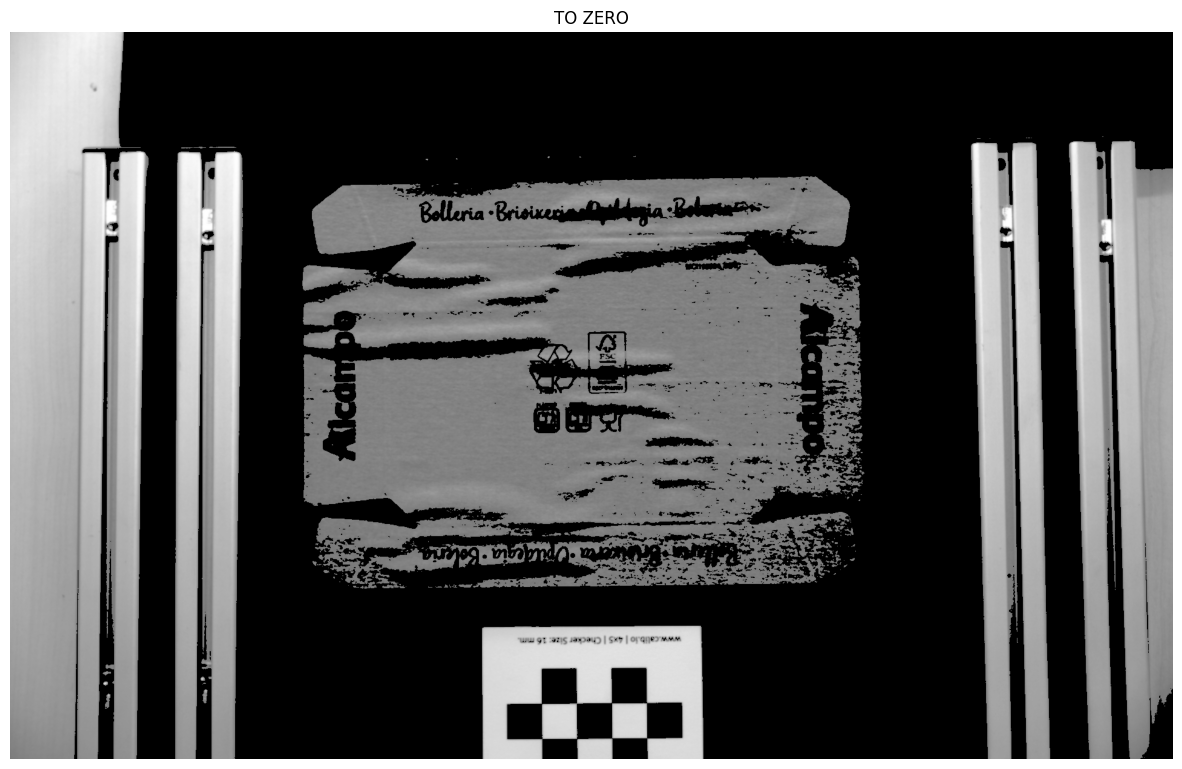

In [59]:
# Thresholding the imnage
thValue = 120
_ , thTOZERO = cv.threshold(udst_crop_img,thValue,255,cv.THRESH_TOZERO)

# Let's see the results
plt.figure(figsize=(15, 10))
plt.imshow(thTOZERO, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("TO ZERO")
plt.axis("off")